/storage/work/ugh5000/.conda/envs/openmc-env/lib/python3.11/site-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


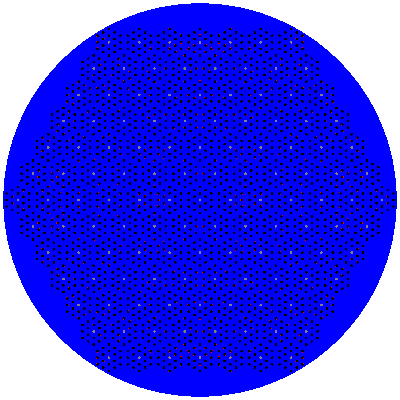

In [22]:
%matplotlib inline 
import numpy as np 
import os 
import math 
os.environ["PATH"] = "/storage/work/ugh5000/.conda/envs/openmc/bin:" + os.environ["PATH"] 
import openmc 
os.environ["OPENMC_CROSS_SECTIONS"] = "/storage/work/ugh5000/openmc_xs/endfb-viii.0-hdf5/cross_sections.xml"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

fuel = openmc.Material(name='uo2') 
fuel.add_nuclide('U235', 0.03) 
fuel.add_nuclide('U238', 0.97) 
fuel.add_nuclide('O16', 2) 
fuel.set_density('g/cm3', 11.5) 

cladding = openmc.Material(name='zircaloy4') 
cladding.add_element('Zr',0.98) 
cladding.add_element('Sn',0.015) 
cladding.add_element('Fe',0.002) 
cladding.add_element('Cr',0.001) 
cladding.add_element('O',0.001) 
cladding.add_element('Hf', 0.001) 
cladding.set_density('g/cm3', 6.34) 

water = openmc.Material(name='h2o') 
water.add_nuclide('H1', 2.0) 
water.add_nuclide('O16', 1.0) 
water.set_density('g/cm3', 1.0) 
water.add_s_alpha_beta('c_H_in_H2O')

ctrl_rod = openmc.Material(name='bc4')
ctrl_rod.add_nuclide('B10', 0.7)
ctrl_rod.add_nuclide('B11', 0.3)
ctrl_rod.add_nuclide('C12', 4)
ctrl_rod.set_density('g/cm3', 2.5)

mats = openmc.Materials([fuel, cladding, water, ctrl_rod]) 
mats.export_to_xml() 


H_core = 225
cyl_uo2 = openmc.ZCylinder(r=1)
cyl_clad = openmc.ZCylinder(r=1.02)
cyl_ctrl = openmc.ZCylinder(r=1.02)
z_max = openmc.ZPlane(z0=H_core, boundary_type='vacuum')
z_min = openmc.ZPlane(z0=-H_core, boundary_type='vacuum')

uo2_region = -cyl_uo2 & -z_max & +z_min
clad_region = +cyl_uo2 & -cyl_clad & -z_max & +z_min
ctrl_region = -cyl_ctrl & -z_max & +z_min

uo2_cell = openmc.Cell(name='fuel')
uo2_cell.region = uo2_region
uo2_cell.fill = fuel

clad_cell = openmc.Cell(name='cladding')
clad_cell.region = clad_region
clad_cell.fill = cladding

ctrl_cell = openmc.Cell(name='rod')
ctrl_cell.region = ctrl_region
ctrl_cell.fill = ctrl_rod

water_cell = openmc.Cell(name='water')
water_cell.region = +cyl_clad & -z_max & +z_min
water_cell.fill = water

water_cell_ctrl = openmc.Cell(name='water_ctrl')
water_cell_ctrl.region = +cyl_ctrl & -z_max & +z_min
water_cell_ctrl.fill = water

fuel_universe = openmc.Universe(cells=[uo2_cell, clad_cell, water_cell])
ctrl_rod_universe = openmc.Universe(cells=[ctrl_cell, water_cell_ctrl])
outer_universe = openmc.Universe(cells=[openmc.Cell(fill=water)])

lat = openmc.HexLattice()
lat.center = (0., 0.)
lat.pitch = (5.,)
lat.outer = outer_universe

outer_ring = [fuel_universe] * 12
middle_ring = [fuel_universe] * 6
inner_ring = [ctrl_rod_universe]
lat.universes = [outer_ring, middle_ring, inner_ring]

a = 2.75 * lat.pitch[0]
outer_boundary = openmc.model.hexagonal_prism(edge_length=a, orientation='y')
main_cell = openmc.Cell(fill=lat, region=outer_boundary & -z_max & +z_min)

assembly_univ = openmc.Universe(cells=[main_cell])

core_lat = openmc.HexLattice()
core_lat.center = (0.,0.)
core_lat.pitch = (np.sqrt(3)*a-0.67,)
core_lat.outer = outer_universe
core_lat.orientation = 'x'

ring_1 = [assembly_univ]
ring_2 = [assembly_univ] * 6
ring_3 = [assembly_univ] * 12
ring_4 = [assembly_univ] * 18
ring_5 = [assembly_univ] * 24
ring_6 = [assembly_univ] * 30
ring_7 = [assembly_univ] * 36
core_lat.universes = [ring_7, ring_6, ring_5, ring_4, ring_3, ring_2, ring_1]

R_core = 150
cyl_core = openmc.ZCylinder(r=R_core, boundary_type='vacuum')

whole_core_cell = openmc.Cell(fill=core_lat, region=-cyl_core & -z_max & +z_min)

geom = openmc.Geometry([whole_core_cell])
geom.export_to_xml()

p = openmc.Plot() 
p.basis = 'xy'       
p.origin = (0, 0, 0) 
p.width = (305, 305)   
p.color_by = 'material'
p.colors = {water: 'blue',fuel: 'black',cladding: 'red',ctrl_rod: 'gray'}

p.path_to_geometry = geom.export_to_xml()

p.to_ipython_image()

In [23]:
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
settings.run_mode = 'eigenvalue'
settings.export_to_xml()

In [27]:
r_grid_num = np.linspace(0,R_core,15)
z_grid_num = np.linspace(-H_core,H_core, 50)
phi_grid_num = np.array([0, 2*np.pi])

mesh = openmc.CylindricalMesh(
    r_grid = r_grid_num,
    z_grid = z_grid_num,
    phi_grid = phi_grid_num,
    origin = (0.0,0.0,0.0)
)

mesh_filter = openmc.MeshFilter(mesh)

flux_tally = openmc.Tally(name='raw_flux')
flux_tally.filter = [mesh_filter]
flux_tally.scores = ['flux']

tallies = openmc.Tallies([flux_tally])
tallies.export_to_xml()


openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [28]:
sp = openmc.StatePoint('statepoint.100.h5') 
tally_sp = sp.get_tally(name="flux_cyl_mesh")


KeyError: 25